                                          Inceptionv3 Model Implementation
                                              Nisha Thankam Cherian

In [193]:
#Importing the libraries
import torch
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision
from sklearn.preprocessing import LabelEncoder, StandardScaler
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
import shutil
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [194]:
#Reading the meta data
metadata = pd.read_csv('metadata.csv')

In [195]:
#Displaying first five rows of metadata
metadata.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [196]:
#Displaying metadata shape
metadata.shape

(6392, 19)

In [197]:
# Checking for missing values and validating column data types
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

#### Data Preprocessing

Metadata has labels and target column which contain only single label data but we need multi-label data for mulitple diagnosis for an input image. Hence labels and target columns are dropped and then recreated using keywords. The labels for left fundus images are created using Left-Diagnostic Keywords column and the labels for right fundus images are created using Right-Diagnostic Keywords column.

Also, filepath, filename and 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O' columns are dropped and recreated again.

In [198]:
#Drop columns from metadata
metadata.drop(columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'], axis=1, inplace= True)

In [199]:
# metadata DataFrame after dropping the above mentioned columns
metadata.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [200]:
#Split Left-Diagnostic Keywords based on comma and add the labels to unique_label set. 
#If the labels do not have keywords corresponding to the specified classes, add it to unique_others set

# Initialize sets to store all unique labels and labels corresponding to other diseases/abnormalities
unique_labels = set()
unique_others = set()
count = 0
# Iterate through each entry in the "Left-Diagnostic Keywords" column of the metadata DataFrame
for i in metadata["Left-Diagnostic Keywords"]:
    #Split based on comma
    labels = i.split('，')
    for label in labels:
        #Add label to unique_labels set
        unique_labels.add(label)
# Define the keywords present in annotations that correspond to the 7 primary Eye conditions
annotations = ['normal','cataract', 'proliferative retinopathy', 'diabetic retinopathy', 'glaucoma', 'hypertensive', 'myopia', 'macular degeneration']

# Iterate through the unique labels and identify those that do not correspond to the primary annotations
for label in unique_labels:
    if not any(annotation in label for annotation in annotations):
        unique_others.add(label)

print(f"Total number of annotations in metadata = {len(unique_labels)}")
print(f"Number of annotations that correpond to other diseases/abnormalities = {len(unique_others)}")
print(f"Number of annotations that correspond to 7 primary Eye conditions = {len(unique_labels) - len(unique_others)}")



Total number of annotations in metadata = 75
Number of annotations that correpond to other diseases/abnormalities = 55
Number of annotations that correspond to 7 primary Eye conditions = 20


In [201]:
#Function to check if a specific term is present in the given text.
#Return 1 if the term is present in the text otherwise return 0.
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [202]:
# Function to check if a specific term is present in the given text and exclude certain terms identified to be associated with different conditions
def has_condns(term, text):
    if term in text and 'chorioretinopathy' not in text and 'hypertensive' not in text:
        return 1
    else:
        return 0

In [203]:
# Initialize new columns with default value 0
metadata["N"]= 0
metadata["C"]= 0
metadata["D"]= 0
metadata["G"]= 0
metadata["H"]= 0
metadata["M"]= 0
metadata["A"]= 0

# Loop through each row in the first half of DataFrame
for l in range(0, 3194):
    metadata.loc[l, "N"] = has_condn("normal fundus", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "C"] = has_condn("cataract", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "D"] = has_condns("retinopathy", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "G"] = has_condn("glaucoma", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "H"] = has_condn("hypertensive", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "M"] = has_condn("myopia", metadata.loc[l, "Right-Diagnostic Keywords"])
    metadata.loc[l, "A"] = has_condn("macular degeneration", metadata.loc[l, "Right-Diagnostic Keywords"])
    

In [204]:
# Loop through each row in the second half of the DataFrame
for j in range(3194, 6392):
    # Check if specific keywords are present in the 'Left-Diagnostic Keywords' column and update corresponding columns
    metadata.loc[j, "N"] = has_condn("normal fundus", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "C"] = has_condn("cataract", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "D"] = has_condns("retinopathy", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "G"] = has_condn("glaucoma", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "H"] = has_condn("hypertensive", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "M"] = has_condn("myopia", metadata.loc[j, "Left-Diagnostic Keywords"])
    metadata.loc[j, "A"] = has_condn("macular degeneration", metadata.loc[j, "Left-Diagnostic Keywords"])

In [205]:
annotations = ['normal','cataract', 'proliferative retinopathy', 'diabetic retinopathy', 'glaucoma', 'hypertensive', 'myopia', 'macular degeneration']
# Create a new column 'O' to indicate other abnormalities
metadata["O"]= 0
# Iterate over each key-value pair in the 'Right-Diagnostic Keywords' column
for key, values in metadata["Right-Diagnostic Keywords"].items():
    # Split the values by comma to extract individual labels
    labels = values.split('，')
    # Check each label to see if it matches any of the primary annotations
    for label in labels:
        # If the label does not match any of the annotations, set 'O' label to 1
        if not any(annotation in label for annotation in annotations):
            # Check if the key falls within the range of the first half of the DataFrame
            if key>=0 and key<3194:
                metadata.loc[key, "O"] = 1
        

In [206]:
# Iterate over each key-value pair in the 'Left-Diagnostic Keywords' column
for l_key, l_values in metadata["Left-Diagnostic Keywords"].items():
    # Split the values by comma to extract individual labels
    l_labels = l_values.split('，')
    
    # Check each label to see if it matches any of the primary annotations
    for label in l_labels:
        # If the label does not match any of the annotations, set 'O' to 1
        if not any(annotation in label for annotation in annotations):
            # Check if the key falls in the second half of the DataFrame
            if l_key>=3194:
                metadata.loc[l_key, "O"] = 1

In [207]:
# Display the metadata after the changes
metadata.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,C,D,G,H,M,A,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,1,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,0,0,0,0,0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,0,1,0,0,0,0,0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,0,0,0,0,0


In [208]:
# Define a function to process multiple rows in the metadata DataFrame and list the diagnoses, label and target
metadata["diagnoses"] = ""
metadata["label"] = ""
metadata["targets"] = ""

def process_path(index, row):
     # Initialize empty lists to store diagnoses, labels, and targets
    diagnoses = []
    label = []
    targets = []

    # Check if 'N' column is equal to 1 (indicating normal fundus)
    if (row['N']==1):
        diagnoses.append("normal")
        label.append('N')
        targets.append(1)
    else: targets.append(0)

    # Check if 'D' column is equal to 1 (indicating diabetes)
    if (row['D']==1):
        diagnoses.append("diabetes")
        label.append('D')
        targets.append(1)
    else: targets.append(0)

    # Check if 'G' column is equal to 1 (indicating glaucoma)
    if (row['G']==1):
        diagnoses.append("glaucoma")
        label.append('G')
        targets.append(1)
    else: targets.append(0)

    # Check if 'C' column is equal to 1 (indicating cataract)
    if (row['C']==1):
        diagnoses.append("cataract") 
        label.append('C')
        targets.append(1)
    else: targets.append(0)

    # Check if 'A' column is equal to 1 (indicating age related macular degeneration)
    if (row['A']==1):
        diagnoses.append("age related macular degeneration")
        label.append('A')
        targets.append(1)
    else: targets.append(0)

    # Check if 'H' column is equal to 1 (indicating hypertension)
    if (row['H']==1):
        diagnoses.append("hypertension") 
        label.append('H')
        targets.append(1)
    else: targets.append(0)

    # Check if 'M' column is equal to 1 (indicating pathological myopia)
    if (row['M']==1):
        diagnoses.append("pathological myopia")
        label.append('M')
        targets.append(1)
    else: targets.append(0)

    # Check if 'O' column is equal to 1 (indicating other diseases/abnormalities)
    if (row['O']==1):
        diagnoses.append("other diseases/abnormalities")
        label.append('O')
        targets.append(1)
    else: targets.append(0)

    # Update the 'diagnoses', 'label', and 'targets' columns for the current row
    row["diagnoses"] = diagnoses
    row["label"] = label
    row["targets"] = targets

    # Update the metadata DataFrame with the modified row
    metadata.loc[index] = row

# Apply the 'process_path' function to each row in the metadata DataFrame and store the results
updated_paths = [process_path(index, row) for index, row in metadata.iterrows()]

In [209]:
#display metadata
metadata.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,C,D,G,H,M,A,O,diagnoses,label,targets
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,1,0,0,0,0,0,0,0,[normal],[N],"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,[normal],[N],"[1, 0, 0, 0, 0, 0, 0, 0]"
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,0,0,0,0,0,[diabetes],[D],"[0, 1, 0, 0, 0, 0, 0, 0]"
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,0,1,0,0,0,0,0,[diabetes],[D],"[0, 1, 0, 0, 0, 0, 0, 0]"
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,0,0,0,0,0,[diabetes],[D],"[0, 1, 0, 0, 0, 0, 0, 0]"


In [210]:
# Initialize a new column 'filename' in the metadata DataFrame to store associated fundus image names
metadata["filename"] = ""

# Iterate over each row in the metadata DataFrame
for index, row in metadata.iterrows():
    # Retrieve the row for the current index in the metadata DataFrame
    cell_value = metadata.loc[index]

    # Determine whether to use 'Left-Fundus' or 'Right-Fundus' based on the index
    if index>=3194:
        sample = cell_value['Left-Fundus']                
    if index<3194:
        sample = cell_value['Right-Fundus']

    # Update the 'filename' column with the appropriate fundus image name
    metadata.loc[index, 'filename'] = sample
    

In [211]:
# Create a new column 'filepath' in the metadata DataFrame to store file paths
metadata["filepath"] = ""

# Get the current working directory path
cwd_path = os.getcwd()

# Define the folder containing preprocessed images
folder = 'preprocessed_images'
# Construct the source path by joining the current working directory with the folder name
src_path = os.path.join(cwd_path, folder)

# Iterate over each row in the metadata DataFrame
for index, row in metadata.iterrows():
    # Retrieve the row for the current index
    cell_value = metadata.loc[index]

    # Get the filename from the current row
    sample = cell_value['filename']

    # Construct the full file path by joining the source path with the filename
    path = os.path.join(src_path, sample)

    # Store the file path in the 'filepath' column of the metadata DataFrame for the current index
    metadata.loc[index, 'filepath'] = path


In [213]:
#Display metadata
metadata.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,C,D,G,H,M,A,O,diagnoses,label,targets,filename,filepath
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,1,0,0,0,0,0,0,0,[normal],[N],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,/usr/cs/grad/masters/2025/ncherian/ocular_dise...
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,[normal],[N],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,/usr/cs/grad/masters/2025/ncherian/ocular_dise...
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,0,0,0,0,0,[diabetes],[D],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,/usr/cs/grad/masters/2025/ncherian/ocular_dise...
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,0,1,0,0,0,0,0,[diabetes],[D],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,/usr/cs/grad/masters/2025/ncherian/ocular_dise...
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,0,0,0,0,0,[diabetes],[D],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,/usr/cs/grad/masters/2025/ncherian/ocular_dise...


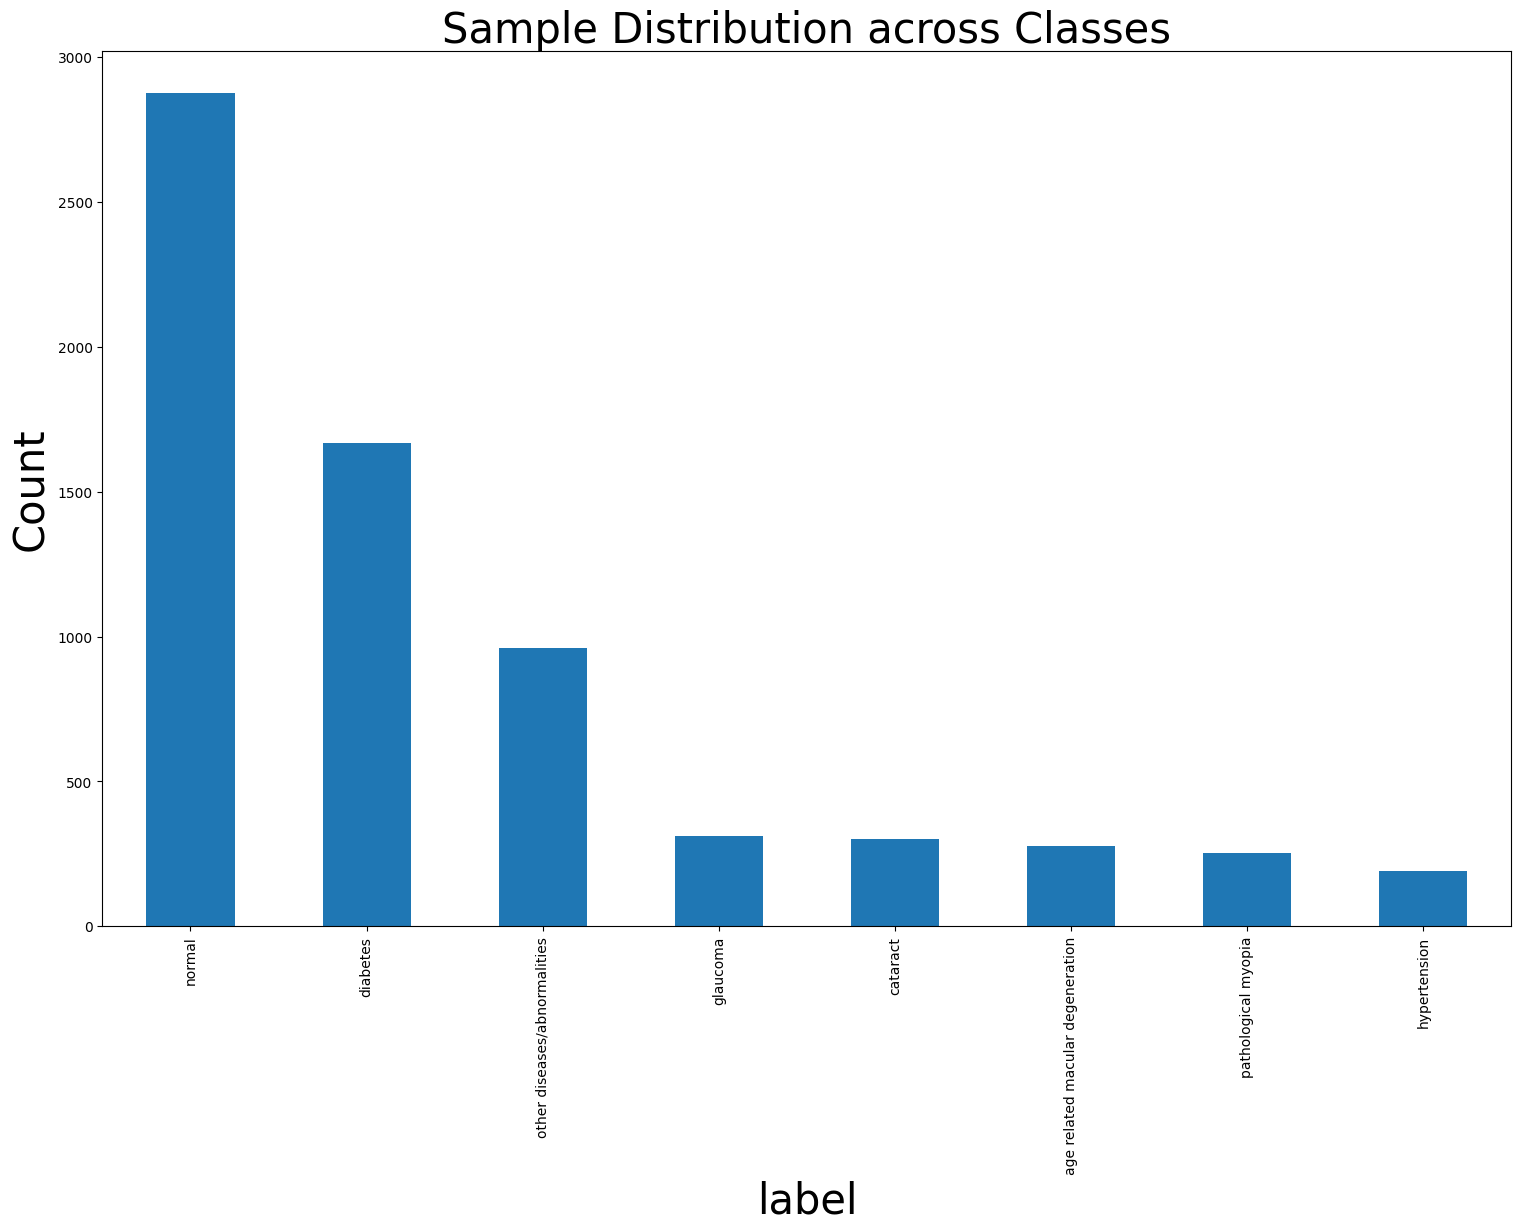

In [214]:
# Getting a sense of what the distribution of diagnoses column looks like

# Create a new figure for the plot with a specified size
fig = plt.figure(figsize=(40,25))

# Add a subplot to the figure
ax1 = fig.add_subplot(221)

# Expanding metadata such that each row corresponds to a single value of the specified column
exploded_metadata = metadata.explode('diagnoses')

# Plot the value counts of the expanded 'diagnoses' column as a bar chart on the subplot
exploded_metadata['diagnoses'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count', size=30)
ax1.set_xlabel('label', size=30)
ax1.set_title('Sample Distribution across Classes', size = 30)
plt.xticks(rotation=90)
plt.show()

In [215]:
# Expanding metadata such that each row corresponds to a single value of the specified column
exploded_metadata = metadata.explode('label')
# Count the occurrences of each value in the 'label' column
count = exploded_metadata['label'].value_counts()
print(count)

label
N    2874
D    1666
O     960
G     313
C     301
A     279
M     253
H     192
Name: count, dtype: int64


#### Determing class weights using Median Frequency Balancing


In [216]:
#Median frequency balancing
# Defining the list of class labels
label = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Function to estimate class weights based on median frequency balancing
def estimate_weights(label):
    class_weights = {}
    weights_aligned = np.zeros_like(label, dtype=np.float64)
    
    # Expanding metadata such that each row corresponds to a single value of the specified column
    exploded_metadata = metadata.explode('label')

    #Counting the occurances of each class label
    class_count = exploded_metadata['label'].value_counts()

    #Counting the total number of samples in the dataset
    total_count = metadata.shape[0]

    #Calculating the frequency of each class label (each class occurance/total occuranes of all classes)
    class_frequency = {}
    for key, cls in class_count.items():
        class_frequency[key] = (cls/total_count)

    #Calculatin median of class frequencies
    class_frequencies = np.array(list(class_frequency.values()), dtype=np.float64)
    median_frequency = np.median(class_frequencies)

    #Calculating weights of each class (median frequency/frequency of each class)
    for lbl in class_frequency:
        class_weights[lbl] = median_frequency/ class_frequency[lbl]
    
    # Aligning the weights with the order of class labels
    for i, v in enumerate(label):
        if v in class_weights:
            weights_aligned[i] = class_weights[v]
    return weights_aligned

# Estimate the class weights 
cls_weights = estimate_weights(label)                                  

# Print the class weights                                  
for i in range(len(cls_weights)):
    print(label[i],":", cls_weights[i])
    

N : 0.10681976339596382
D : 0.1842737094837935
G : 0.9808306709265175
C : 1.0199335548172759
A : 1.1003584229390682
H : 1.5989583333333333
M : 1.2134387351778657
O : 0.31979166666666664


In [217]:
# Computing the weights of individual classes and converting them to tensors
class_weights = estimate_weights(label)
class_weights = torch.FloatTensor(class_weights)

In [218]:
#Defining a custom dataset to facilitate data preparation and transformation to make data suitable for loading into memory (data loading)
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms

#Custom dataset for Ocular Disease Recognition
class OcularDiseaseRecognition(Dataset):

    # Passed arguments to function = X, y, root_dir, dataset
    # X - is a series containing image filenames
    # y - is a series containing labels
    # root_dir (str) - is the path to directory containing the images 
    # dataset (str) - indicates whether the dataset is for training or testing

    def __init__(self, X, y, root_dir, dataset):
        
        self.labels_frame = X
        self.root_dir = root_dir
        self.label = y
        self.dataset = dataset

        # Defining transformations for training and testing data
        self.train_transform = transforms.Compose([
                                                 transforms.Resize((299, 299)),
                                                 transforms.ToTensor(),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.RandomRotation(degrees=60),
                                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

        
        self.test_transform = transforms.Compose([
                                                 transforms.Resize((299, 299)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
            
    # Function to return the number of samples in the dataset
    def __len__(self):
        return len(self.labels_frame)
    
    # Function to retrieve an item from the dataset
    def __getitem__(self, idx):
        """Retrieve an item from the dataset."""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Construct the complete file path for the image by joining the root directory path and the filename
        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx])
        image = Image.open(img_name)
        # Retrieve the label for the current sample from the label series
        target = self.label.iloc[idx]
        # Convert the label to a NumPy array for compatibility with PyTorch tensors
        target = np.array(target)
        # Convert the label to a PyTorch tensor
        target = torch.tensor(target)
        
        # Apply appropriate transformation based on the dataset type (train or test)
        if self.dataset == 'train':
            image = self.train_transform(image)
        elif self.dataset == 'test':
            image = self.test_transform(image)
            
        sample = {'image': image, 'labels': target}

        return sample

In [219]:
#Display a random image name and its corresponding labels and target tensor 
n = 73
img_name = metadata.iloc[n, 18]
class_name =  metadata.iloc[n, 15]
target = metadata.iloc[n, 17]

print('Image name: {}'.format(img_name))
print('Class Name: {}'.format(class_name))
print('Target: {}'.format(target))

Image name: 89_right.jpg
Class Name: ['diabetes', 'other diseases/abnormalities']
Target: [0, 1, 0, 0, 0, 0, 0, 1]


In [220]:
# Initializing an empty lists to store file paths and targets
Xt = []
yt = []
features = None # Initialize features
labels = None # Initialize labels
# Initializing an empty list to store labels
label = []

In [221]:
# Extracting file paths from the 'filepath' column of metadata 
Xt = metadata['filepath']
# Extracting targets from the 'targets' column of metadata 
yt = metadata['targets']

In [222]:
# Extracting a sample of file paths and targets from metadata 
yt_sample = yt.sample(25,random_state=42).to_list()
Xt_sample = Xt.sample(25,random_state=42).to_list()

#### Train, Test and Validation Split
We split the entire dataset into 3 parts:

- Train: 70%
- Test: 15%
- Validation: 15%

In [223]:
# 70 % training, 15% validating, 15% testing
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.3, shuffle=True) 

# Further splitting the testing set into validation and testing sets
# 50% validation, 50% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)  

In [224]:
# Resetting the index of the training data to ensure it starts from 0
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Resetting the index of the validation data to ensure it starts from 0
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

# Resetting the index of the testing data to ensure it starts from 0
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [225]:
# Printing the size of the training data, testing data and validation data
print(f"Train data size= {len(X_train)}")
print(f"Test data size = {len(X_valid)}")
print(f"Validation data size = {len(X_test)}")

Train data size= 4474
Test data size = 959
Validation data size = 959


#### Creating train, test and validation datasets by calling custom dataset function (OcularDiseaseRecognition())

In [226]:
import torch
from torchvision import transforms

# Creating the training dataset
train_set = OcularDiseaseRecognition(X= X_train, y= y_train, root_dir=path, dataset='train') 

# Creating the validation dataset
valid_set = OcularDiseaseRecognition(X= X_valid, y= y_valid, root_dir=path, dataset='test')

# Creating the testing dataset
test_set = OcularDiseaseRecognition(X= X_test, y= y_test, root_dir=path, dataset='test')

In [227]:
# Retrieve a single sample from the training dataset to view its contents
train_set[1]

{'image': tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
         [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          ...,
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
         [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
          [-2.2214,

In [228]:
# Generate lists of indices for the training, validation, and testing sets
# These lists will be used by RandomSampler to sample batches of data during training, validation, and testing
train_idx = list(range(len(X_train))) 
valid_idx = list(range(len(X_valid))) 
test_idx = list(range(len(X_test))) 

In [229]:
# Define RandomSamplers for obtaining training, testing and validation batches
# These samplers will be used to sample batches of data during training, validation, and testing.
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

 #### Using Pytorch data loader to load dataset into the memory

In [230]:
# Prepare data loaders by combining dataset and sampler
batch_size = 50 # Define batch size for training data
validation_batch_size = 10 # Define batch size for validation data
test_batch_size = 10 # Define batch size for testing data

# Create data loader for training set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler)

# Create data loader for validation set
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, 
    sampler=valid_sampler)

# Create data loader for testing set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    sampler=test_sampler)

In [164]:
# Calculate and view the number of batches in the training data loader
num_train_batches = len(train_loader)
num_train_batches

90

#### View sample of training data from each class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

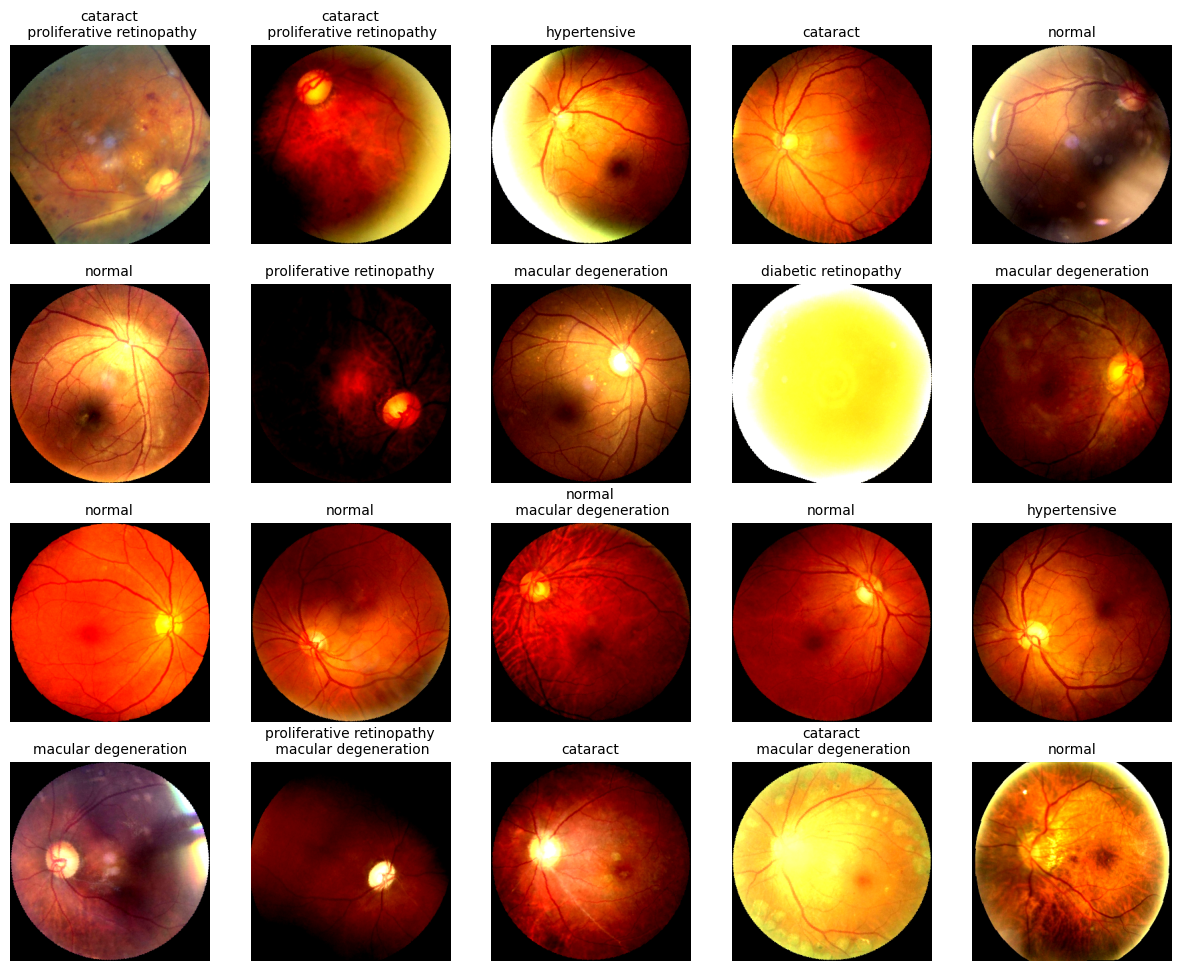

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Define the classes
classes = ['normal', 'diabetes', 'glaucoma', 'cataract', 'age related macular degeneration', 'hypertension', 'pathological myopia', 'other diseases/abnormalities']

# Function to show an image with multiple labels
def imshow(img, labels):
    # Denormalize the image (if it was normalized)
    img = img / 2 + 0.5
    npimg = img.numpy()
    label_ind = [j for j, label in enumerate(labels) if label == 1]
    labels = [annotations[j] for j in label_ind]
    plt.title('\n '.join(labels), fontsize =10)  # Display all corresponding labels
    plt.imshow(img.permute(1, 2, 0))  # Assuming img is a tensor
    plt.axis('off')

# Get some random training images
dataiter = iter(train_loader)
sample = next(dataiter)

# Plot the images in the batch, along with the corresponding labels
plt.figure(figsize=(15, 15))
batch_size = 20
for idx in np.arange(batch_size):
    plt.subplot(5, 5, idx + 1)
    imshow(sample['image'][idx], sample['labels'][idx].tolist())  # Convert label tensor to list

plt.show()

### Define Inception V3 Model

In [232]:
from torch import nn

#Get the number of classes. num_classes will have value 8
num_classes = len(classes)
#Load the pre-trained inception_v3 model
net = torchvision.models.inception_v3(pretrained = True)
# Replace the last fully connected layer to match the number of classes
net.fc = nn.Linear(net.fc.in_features, num_classes)
# Disable the use of auxiliary classifiers during training
net.aux_logits = False
# Move the model to GPU
net = net.to(device)

/usr/cs/grad/masters/2025/ncherian/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/cs/grad/masters/2025/ncherian/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Define Loss function and optmizer

In [233]:
import torch.optim as optim
# Move the class weights tensor to GPU
class_weights = class_weights.to(device)
#Define the loss function with class weights. Loss function is Binary Cross Entropy loss
criterion = nn.BCEWithLogitsLoss(weight=class_weights)
# Define the optimizer for training the model with learning rate 0.0001
optimizer = optim.Adam(net.parameters(), lr=1e-4)
# Print the model architecture
print(net)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [234]:
#Reference - https://medium.com/miccai-educational-initiative/skin-cancer-image-classification-an-educational-guide-2a043a1beb59
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to calculate the number of correct predictions
def get_accuracy(predicted, labels):
    # Initialize variables to count batch length and correct predictions
    batch_len, correct= 0, 0
    # Calculate batch length
    batch_len = labels.size(0)
    # Count the number of correct predictions in the batch
    correct = (predicted == labels).all(dim=1).sum().item()
    return batch_len, correct

# Function to evaluate the model on the validation set
def evaluate(model, val_loader):
    # Initialize variables for loss, total number of samples, and total number of correct predictions
    losses= 0
    num_samples_total=0
    correct_total=0
    # Initialize lists to store predicted labels, true labels, and predicted probabilities
    predicted_labels = []
    true_labels = []
    predicted_probs = []
    # Set the model to evaluation mode
    model.eval()
    # Iterate over the validation loader
    for i, data in enumerate(valid_loader):
        # Get the inputs and labels from validation data loader
        inputs, labels = data['image'], data['labels']
        # Move inputs and labels to the appropriate device (here GPU)
        labels, inputs = labels.to(device, dtype=torch.float), inputs.to(device, dtype=torch.float)
        # Forward pass to obtain the model predictions
        out = model(inputs)
        # Apply sigmoid activation to convert raw outputs to probabilities
        predicted = torch.sigmoid(out)
        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        predicted_bin = (predicted > 0.5).float()
        # Calculate the loss for the current batch
        loss = criterion(out, labels)
        # Accumulate the loss
        losses += loss.item() 
        # Get the number of samples and correct predictions for the current batch
        b_len, corr = get_accuracy(predicted_bin, labels)
        # Accumulate the total number of samples and correct predictions
        num_samples_total +=b_len
        correct_total +=corr
        # Extend the lists with predicted labels, true labels, and predicted probabilities
        predicted_labels.extend(predicted_bin.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())
        predicted_probs.extend(predicted.cpu().detach().numpy()) 

    # Compute accuracy as the ratio of correct predictions to total samples
    accuracy = correct_total/num_samples_total
    # Compute average loss over all batches
    losses = losses/len(val_loader)
    
    # Convert true_labels and predicted_labels to numpy arrays for sklearn metrics
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute precision, recall, F1 score, and AUC using sklearn metrics
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    auc = roc_auc_score(true_labels, predicted_probs, average='weighted')  
    
    return losses, accuracy, precision, recall, f1, auc

#### Training the Model
- Load the training data into memory in batches
- Pass batches of input images to the model to obtain predictions
- Pass the model's raw outputs through the sigmoid activation function to obtain probabilities
- Compute the gradients of the loss with respect to the model's parameters (weights and biases)
- Update model parameters to minimize loss using the gradients computed during the backward pass
- Monitor metrics like loss, accuracy, precision, recall, F1 score, and AUC on both training and validation datasets
- Print and store metrics for each epoch to facilitate visualization of training progress

In [236]:
#Reference - https://medium.com/miccai-educational-initiative/skin-cancer-image-classification-an-educational-guide-2a043a1beb59
# Number of epochs for training (loops over the dataset)
num_epochs = 28
# Initialize lists to store training and validation metrics
accuracy = []
val_accuracy = []
losses = []
val_losses = []

# Loop over the specified number of epochs
for epoch in range(num_epochs):
    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0

    # Iterate over the train dataloader
    for i, data in enumerate(train_loader):
        # Get the inputs and labels from the train dataloader
        inputs, labels = data['image'], data['labels']
        # Move inputs and labels to the appropriate device (here GPU)
        labels, inputs = labels.to(device, dtype=torch.float), inputs.to(device, dtype=torch.float)
        # set the parameter gradients to zero
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()   # Backward pass
        optimizer.step()  # Update the weights
        
        # Apply sigmoid activation to convert raw outputs to probabilities
        predicted = torch.sigmoid(outputs)
        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        predicted_binary = (predicted > 0.5).float()
        #compute training accuracy 
        b_len, corr = get_accuracy(predicted_binary, labels)
        num_samples_total +=b_len
        correct_total +=corr
        # Accumulate the running loss
        running_loss += loss.item()

    # Compute average training loss and accuracy for the epoch
    running_loss /= len(train_loader)
    train_accuracy = correct_total/num_samples_total
     # Evaluate the model on the validation set
    val_loss, val_acc, val_precision, val_recall, val_f1, val_auc = evaluate(net, valid_loader)
    
    # Print training and validation metrics for the epoch
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Precision: %.3f  Recall: %.3f  F1 Score: %.3f   AUC: %.3f' % (val_precision, val_recall, val_f1, val_auc))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))
    
    # Append the metrics to the corresponding lists for visualization
    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)

# Print a message indicating the end of training
print('Finished Training')

Epoch: 1
Loss: 0.171  Accuracy:0.229
Precision: 0.270  Recall: 0.372  F1 Score: 0.309   AUC: 0.722
Validation Loss: 0.125  Val Accuracy: 0.385
Epoch: 2
Loss: 0.121  Accuracy:0.327
Precision: 0.671  Recall: 0.291  F1 Score: 0.324   AUC: 0.754
Validation Loss: 0.124  Val Accuracy: 0.277
Epoch: 3
Loss: 0.111  Accuracy:0.374
Precision: 0.615  Recall: 0.408  F1 Score: 0.365   AUC: 0.769
Validation Loss: 0.112  Val Accuracy: 0.410
Epoch: 4
Loss: 0.101  Accuracy:0.434
Precision: 0.641  Recall: 0.416  F1 Score: 0.439   AUC: 0.792
Validation Loss: 0.100  Val Accuracy: 0.409
Epoch: 5
Loss: 0.097  Accuracy:0.434
Precision: 0.606  Recall: 0.401  F1 Score: 0.454   AUC: 0.808
Validation Loss: 0.103  Val Accuracy: 0.400
Epoch: 6
Loss: 0.090  Accuracy:0.468
Precision: 0.693  Recall: 0.515  F1 Score: 0.487   AUC: 0.819
Validation Loss: 0.101  Val Accuracy: 0.514
Epoch: 7
Loss: 0.090  Accuracy:0.498
Precision: 0.622  Recall: 0.484  F1 Score: 0.454   AUC: 0.815
Validation Loss: 0.103  Val Accuracy: 0.487

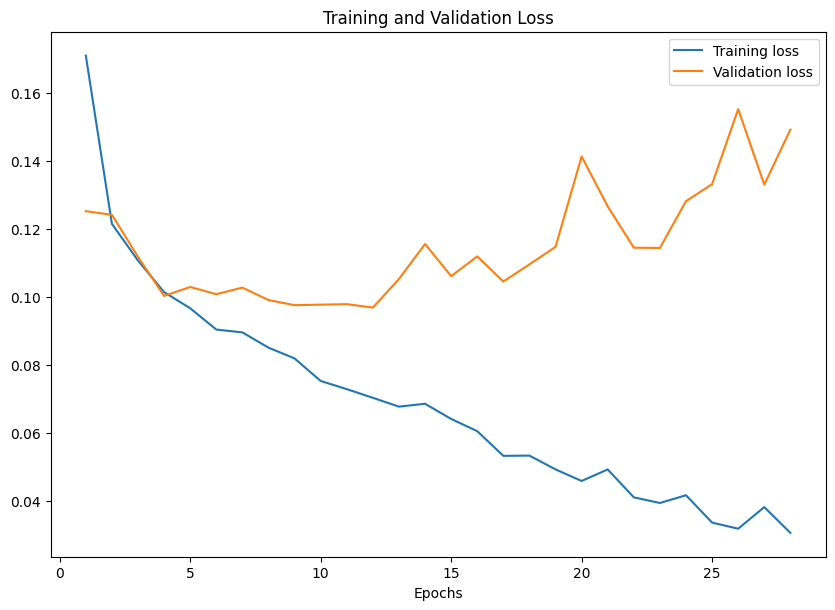

<Figure size 640x480 with 0 Axes>

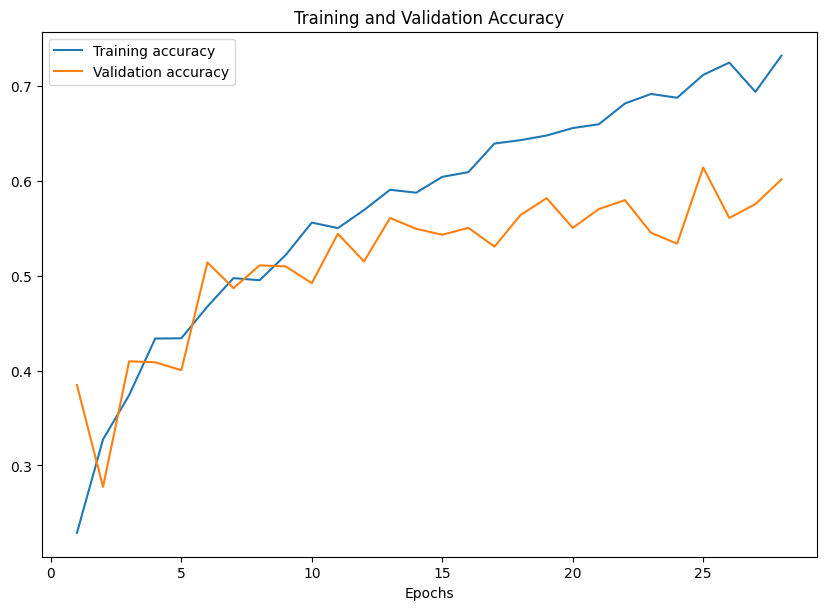

<Figure size 640x480 with 0 Axes>

In [237]:
#Plot training and validation loss curve as well as training and validation accuracy curve
#Reference - https://medium.com/miccai-educational-initiative/skin-cancer-image-classification-an-educational-guide-2a043a1beb59

# Define the range of epochs for plotting
epoch = range(1, num_epochs+1)

# Create a figure to plot the training and validation losses
fig = plt.figure(figsize=(10, 15))
# Subplot for training and validation losses
plt.subplot(2,1,2)

# Plot the training loss over epochs
plt.plot(epoch, losses, label='Training loss')
# Plot the validation loss over epochs
plt.plot(epoch, val_losses, label='Validation loss')

plt.title('Training and Validation Loss') # Set title for the subplot
plt.xlabel('Epochs') # Set label for x-axis
plt.legend() # Add legend to the plot
plt.figure()
plt.show() # Show the plots

# Create a new figure to plot training and validation accuracies
fig = plt.figure(figsize=(10, 15))
# Subplot for training and validation accuracies
plt.subplot(2,1,2)

# Plot the training accuracy over epochs
plt.plot(epoch, accuracy, label='Training accuracy')
# Plot the validation accuracy over epochs
plt.plot(epoch, val_accuracy, label='Validation accuracy')

plt.title('Training and Validation Accuracy') # Set title for the subplot
plt.xlabel('Epochs') # Set label for x-axis
plt.legend() # Add legend to the plot
plt.figure()
plt.show() # Show the plots

#### Test the model on test images and evaluate the model

In [238]:
# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Initialize lists to store predicted labels, true labels, predicted probabilities, sigmoid probabilities, and image data
predicted_labels = []
true_labels = []
predicted_probs = []
sigmoid_probs = []
image_list = []

# Set the model to evaluation mode 
net.eval()
# Disable gradient calculation during evaluation
with torch.no_grad():
    # Iterate over the test dataloader
    for i, data in enumerate(test_loader):
        # Get the inputs and labels from test dataloader
        inputs, labels = data['image'], data['labels']
        # Move inputs and labels to the appropriate device (here GPU)
        labels, inputs = labels.to(device, dtype=torch.float), inputs.to(device, dtype=torch.float)
        # Forward pass to get the outputs
        outputs = net(inputs)
        # Apply sigmoid activation to convert raw outputs to probabilities
        predicted = torch.sigmoid(outputs)
        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        predicted_binary = (predicted > 0.5).float()

        # Accumulate total and correct predictions
        total += labels.size(0)
        correct += (predicted_binary == labels).all(dim=1).sum().item()

        # Extend lists with predicted labels, true labels, predicted probabilities, sigmoid probabilities, and image data
        predicted_labels.extend(predicted_binary.cpu().detach().numpy())
        true_labels.extend(labels.cpu().detach().numpy())
        sigmoid_probs.extend(predicted.cpu().detach().numpy())
        image_list.extend(inputs.cpu().detach().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
sigmoid_probs = np.array(sigmoid_probs)
image_list = np.array(image_list)

# Calculate AUC
auc = roc_auc_score(true_labels, predicted_labels, average='weighted')

# Print results
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print('AUC: %.2f' % auc)

Accuracy of the network on the test images: 61 %
AUC: 0.76


#### Model evaluation using classification report

In [239]:
from sklearn.metrics import classification_report
target_names = ['normal', 'diabetes', 'glaucoma', 
          'cataract','age related macular degeneration', 'hypertension', 'pathological myopia', 'other diseases/abnormalities']
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print(report)

                                  precision    recall  f1-score   support

                          normal       0.72      0.85      0.78       434
                        diabetes       0.71      0.52      0.60       230
                        glaucoma       0.52      0.54      0.53        46
                        cataract       0.85      0.50      0.63        44
age related macular degeneration       0.69      0.71      0.70        41
                    hypertension       0.30      0.14      0.19        21
             pathological myopia       0.95      0.80      0.86        44
    other diseases/abnormalities       0.68      0.39      0.50       157

                       micro avg       0.71      0.65      0.68      1017
                       macro avg       0.68      0.56      0.60      1017
                    weighted avg       0.71      0.65      0.67      1017
                     samples avg       0.67      0.66      0.66      1017



/usr/cs/grad/masters/2025/ncherian/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


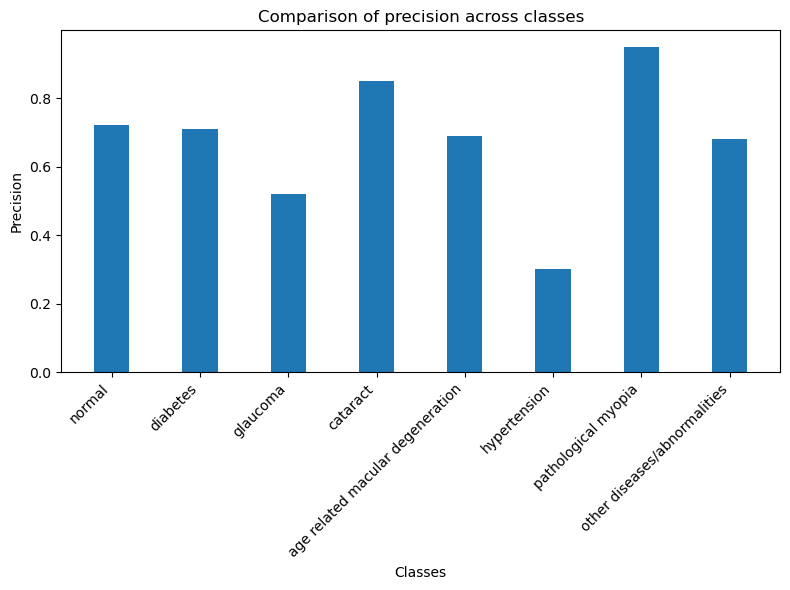

In [4]:
#Bar graph showing the precision values for different classes.
precision_values = [0.72, 0.71, 0.52, 0.85, 0.69, 0.30, 0.95, 0.68]

target_names = ['normal', 'diabetes', 'glaucoma', 
          'cataract','age related macular degeneration', 'hypertension', 'pathological myopia', 'other diseases/abnormalities']

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(target_names, precision_values,width=0.4)
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Comparison of precision across classes')
#Rotate the x-labels by 45 degress as the names are long
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()


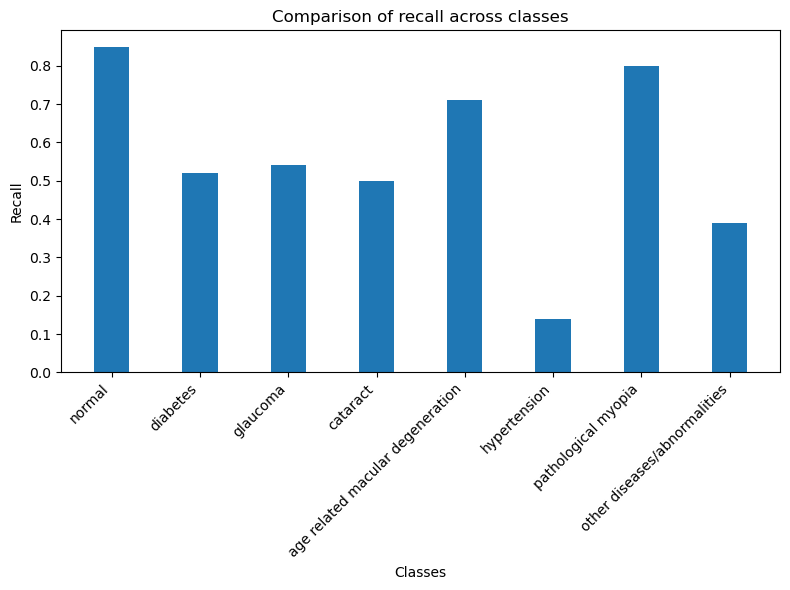

In [5]:
#Bar graph showing the recall values for different classes.
recall_values = [0.85, 0.52, 0.54, 0.50, 0.71, 0.14, 0.80, 0.39]

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(target_names, recall_values,width=0.4)
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Comparison of recall across classes')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

#### Model evaluation using confusion matrix

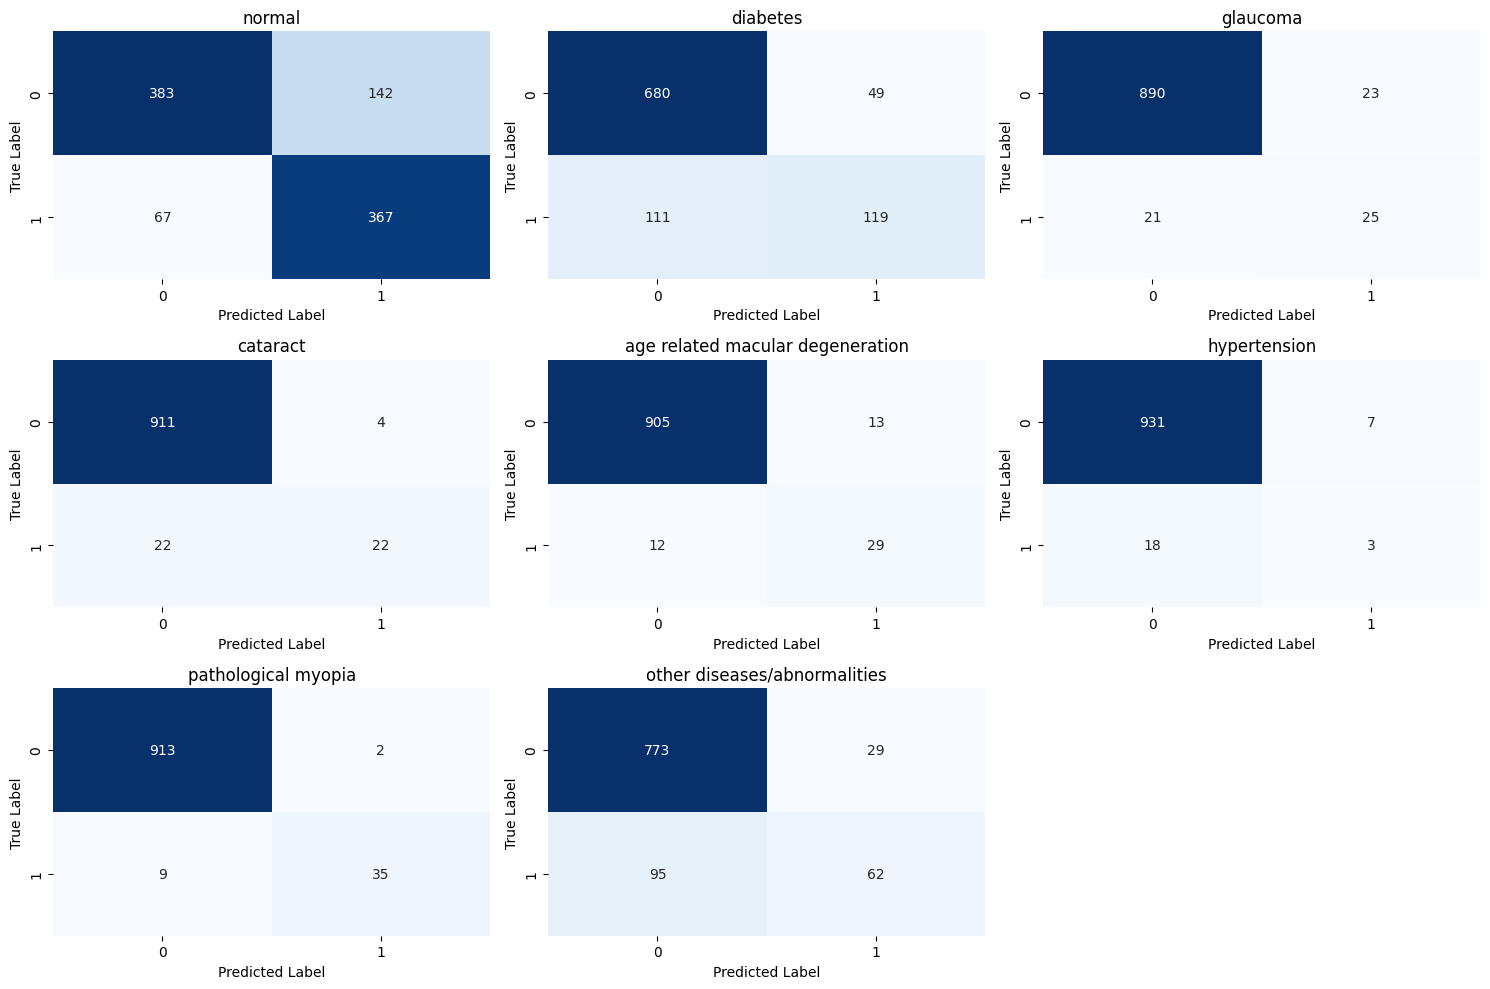

In [242]:
# Calculate confusion matrix and plot confusion matrix heatmap
from sklearn.metrics import multilabel_confusion_matrix

# Calculate the confusion matrix using multilabel_confusion_matrix function
conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

# Define the number of classes and class labels
num_classes = 8
classes = [ 'normal', 'diabetes', 'glaucoma', 
          'cataract','age related macular degeneration', 'hypertension', 'pathological myopia', 'other diseases/abnormalities']

# Plot the confusion matrix heatmap
plt.figure(figsize=(15, 10))
for i in range(num_classes):
    plt.subplot(3, 3, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(classes[i])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()

 #### Visualizing a set of images along with their associated predicted probabilities 

In [246]:
# Select a subset of images, predicted labels, predicted probabilities, and true labels for visualization
image_array = image_list[5:10]
label_array = predicted_labels[5:10]
probability_array = sigmoid_probs[5:10]
true_label_array = true_labels[5:10]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


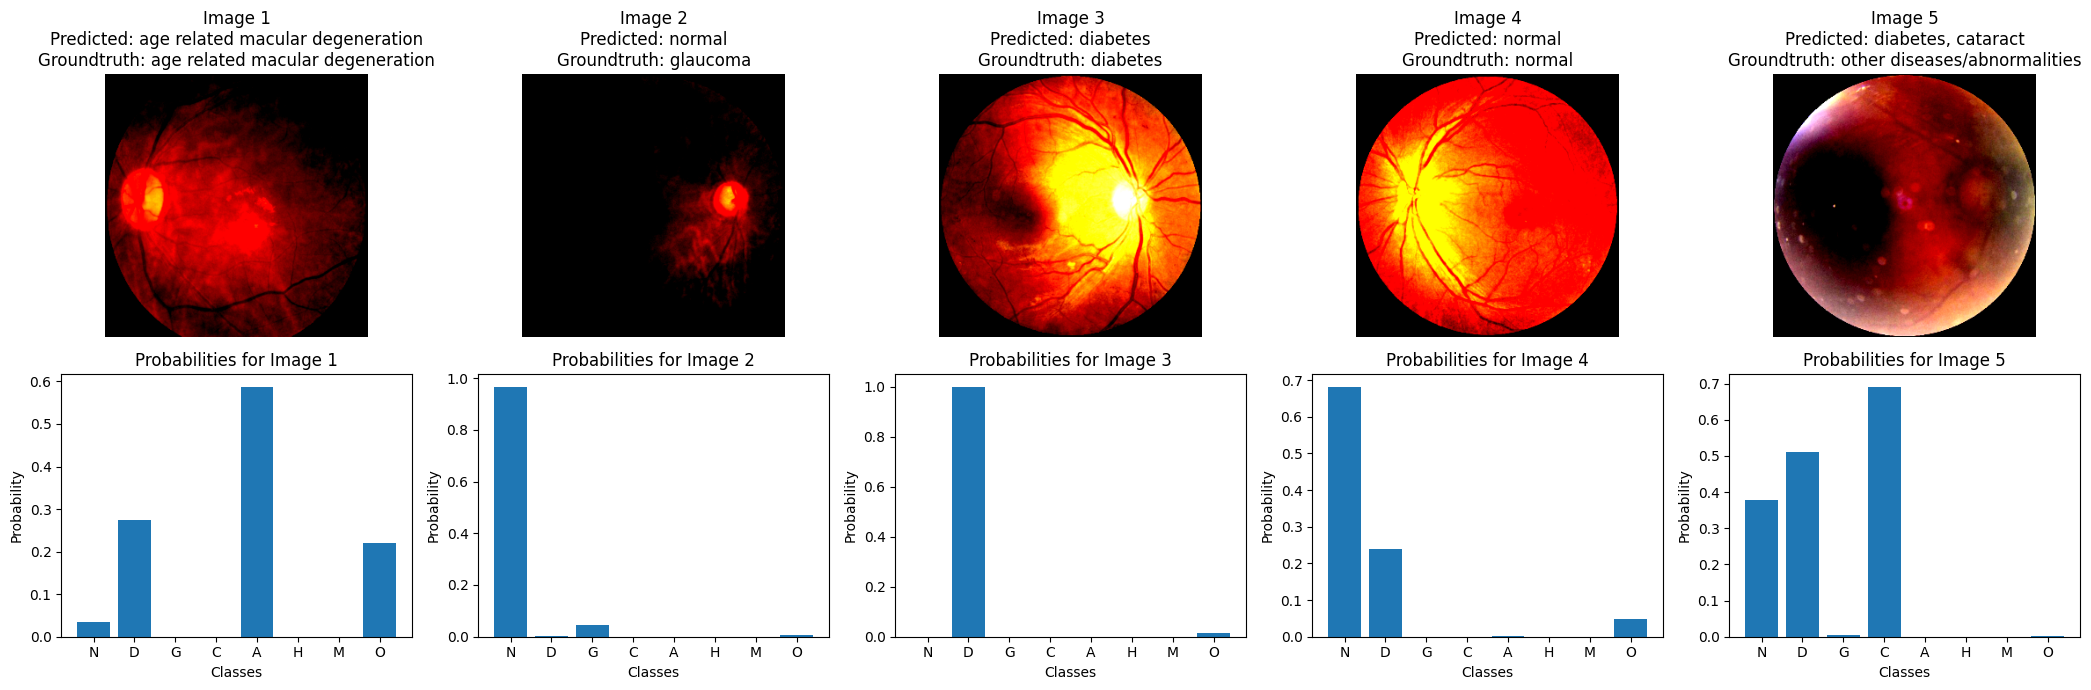

In [247]:
# Get the shape of the sigmoid probability array
num_samples, num_classes = probability_array.shape

# Creating a new figure object for plotting 
plt.figure(figsize=(21, 7))

# Iterate over each sample
for i in range(num_samples):
    # Create a subplot for each sample
    plt.subplot(2, num_samples, i+1)
    
    # Plot the image
    plt.imshow(image_array[i].transpose(1, 2, 0))  # Assuming image_array is in the shape (num_samples, channels, height, width)
    plt.axis('off')
    
    # Get the associated labels for the current sample
    associated_predicted_labels = [classes[j] for j in range(num_classes) if label_array[i][j] == 1]
    associated_true_labels = [classes[j] for j in range(num_classes) if true_label_array[i][j] == 1]
    
    # Set labels and title for each subplot
    plt.title(f'Image {i+1}\nPredicted: {", ".join(associated_predicted_labels)}\nGroundtruth: {", ".join(associated_true_labels)}')
    
    # Create a subplot for the corresponding bar plot
    plt.subplot(2, num_samples, num_samples+i+1)
    
    # Set the position of each bar
    positions = np.arange(num_classes)
    
    # Plot the bars for each sample
    plt.bar(positions, probability_array[i], width=0.8)
    
    # Set labels and title for each subplot
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title(f'Probabilities for Image {i+1}')
    plt.xticks(positions, ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'])  # Adjust xticks as needed

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()